In [1]:
import torch
from trainer import *
from torch.utils.data import DataLoader
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from models.CNN import StrainEnergyCANN_Ani
from sklearn.metrics import r2_score
from typing import Optional

# Предобработка данных

In [2]:
path_to_data = r"..\..\data\GoreTex"
# tensl_data_path = r"..\..\data\PDMS\Shear_pdms.csv"
# shear_data_path = r"..\..\data\PDMS\Tensile_pdms.csv"
# experiments_path = [compr_data_path, tensl_data_path, shear_data_path]

In [3]:
def get_list_of_paths_to_experiments_type(experiment="uniaxial"):
    experiment_type_path = os.path.join(path_to_data, experiment)
    l = []
    for file in os.listdir(experiment_type_path):
        l.append(os.path.join(experiment_type_path, file))
    return l

def load_and_extract(file_path, experiment_type):
    df = pd.read_csv(file_path)
    df['experiment_type'] = experiment_type
    return df[['lambda_clamps_X', 'lambda_clamps_Y', 'mean_stress_x_mpa', 'mean_stress_y_mpa', 'experiment_type']]

get_list_of_paths_to_experiments_type()

['..\\..\\data\\GoreTex\\uniaxial\\GoreTex09mmUniX.csv',
 '..\\..\\data\\GoreTex\\uniaxial\\GoreTex09mmUniY.csv']

In [4]:
experiment = "uniaxial"
experiments_path = get_list_of_paths_to_experiments_type(experiment)
data_frames = [load_and_extract(file, file[-11:-4]) for file in experiments_path]

# print(data_frames)

df = pd.concat(data_frames, ignore_index=True)
thinned_data_frames = []
num_points = 100

sampled_df_list = []

for df in data_frames:
    indices = np.linspace(10, len(df) - 1, num_points, dtype=int)
    # df[1] = df[1] / 10**6
    sampled_df = pd.DataFrame(df.iloc[indices].copy())
    # print(type(sampled_df))
    sampled_df['lambdas'] = list(zip(sampled_df['lambda_clamps_X'], sampled_df['lambda_clamps_Y']))
    sampled_df['stresses'] = list(zip(sampled_df['mean_stress_x_mpa'], sampled_df['mean_stress_y_mpa']))
    sampled_df_list.append(sampled_df[:50])
    # thinned_df = df.iloc[::len(df) // 20, :]  # Выбор каждого 45-го значения
    # thinned_data_frames.append(thinned_df)
data_frames = sampled_df_list
data_frames = data_frames
# sampled_df_list[0]


In [5]:
I1_bx = lambda lam1, lam2: lam1**2 + lam2**2 + 1 / (lam1 * lam2)**2
I2_bx = lambda lam1, lam2: 1 / lam1**2 + 1 / lam2**2 + (lam1 * lam2)**2
I4_bx = lambda lam1, lam2: lam1**2  + math.cos(math.pi / 4)**2 + lam2 * math.sin(torch.pi / 4)**2
I5_bx = lambda lam1, lam2: lam1**2  + math.cos(math.pi / 4)**4 + lam2 * math.sin(torch.pi / 4)**4

F_bx = lambda lam1, lam2: ([lam1, 0, 0], [0, lam2, 0], [0, 0, 1 / (lam1 * lam2)])


In [6]:
mechanical_variables = {
    "I1": I1_bx,
    "I2": I2_bx,
    "I4": I4_bx,
    "I5": I5_bx,

    "F": F_bx,
    # "exp_type": [(lambda x: 1), (lambda x: 0)] # 1 - torsion&compression, 0 - shear
    # "torsion_compression": (lambda x: 1)
}

# calculate I1, I2, F from lambda (torsion&compression and shear)
for variable in mechanical_variables.keys():
    func_calc = mechanical_variables.get(variable)

    for data_frame in data_frames:
        data_frame[variable] = data_frame['lambdas'].apply(lambda lambdas: func_calc(lambdas[0], lambdas[0]))


C:\Users\User\AppData\Local\Temp\ipykernel_6652\2117353720.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[variable] = data_frame['lambdas'].apply(lambda lambdas: func_calc(lambdas[0], lambdas[0]))
C:\Users\User\AppData\Local\Temp\ipykernel_6652\2117353720.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[variable] = data_frame['lambdas'].apply(lambda lambdas: func_calc(lambdas[0], lambdas[0]))
C:\Users\User\AppData\Local\Temp\ipykernel_6652\2117353720.py:17: SettingWithCopyWar

In [7]:
experiments = ['Compression', 'Tensile', 'Shear']
combined_data = pd.concat(data_frames).reset_index(drop=True, inplace=False)
# combined_data.columns = ['lambda1', 'P_experimental', 'I1', 'I2', 'F', 'experiment_type']
combined_data.pop("lambdas")
combined_data.pop("stresses")
experiment_type = combined_data.pop("experiment_type")
combined_data["experiment_type"] = experiment_type
combined_data
combined_data.to_csv( "Uniaxial.csv")
# combined_data = combined_data["lambda_clamps_X", "lambda_clamps_Y",	"mean_stress_x_mpa", "mean_stress_y_mpa", "experiment_type" 

In [8]:
# new_combined_data = pd.DataFrame(columns=["lambdas, 

In [9]:
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
import copy 

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # self.features = [dataframe[0],dataframe[2], dataframe[3], dataframe[4], dataframe[5]]
        # self.targets  = dataframe[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = copy.deepcopy([*self.data.iloc[idx]])
        target1 = features.pop(2)
        target2 = features.pop(2)
        target = torch.tensor([target1, target2])
        return features, target

    def to_tensor(self):
        for column in self.data.columns:
            if column != "experiment_type":
                self.data[column] = self.data[column].apply(
                    lambda x: torch.tensor(x, dtype=torch.float32)).copy()


In [10]:
start = 0
end = -1
train_dataset = CustomDataset(combined_data[start:end].copy())
test_dataset = CustomDataset(combined_data.copy())
f, t = train_dataset[1]
# lam, i1, i2, F, exp_type = f
print(f)
print(t)

[1.0742857142857145, 1.0742857142857145, 3.058973599458596, 3.0648906631089927, 2.1912326530612254, 1.6726612244897965, ([1.0742857142857145, 0, 0], [0, 1.0742857142857145, 0], [0, 0, 0.8664837030330463]), '9mmUniX']
tensor([ 3.1135e-03, -8.6655e-05], dtype=torch.float64)


In [11]:
def init_loaders(experiments:Optional[str]=["Shear", "Tensile", "Comression"]):
    if type(experiments) == str:
        experiments = [experiments]
    elif type(experiments) == list:
        df = pd.concat([combined_data[combined_data["experiment_type"] == experiment] for experiment in experiments]).reset_index(drop=True, inplace=False)
    else:
        df=combined_data
    train_dataset = CustomDataset(df.copy())
    test_dataset = CustomDataset(combined_data.copy())
    
    train_dataset.to_tensor()
    test_dataset.to_tensor()
    
    train_data_loader = DataLoader(
                            train_dataset,
                            shuffle=True,
                            # num_workers=1,
                            pin_memory=False
    )
    test_data_loader = DataLoader(
                            test_dataset,
                            shuffle=False,
                            # num_workers=1,
                            pin_memory=False
    )

    return train_data_loader, test_data_loader 

In [12]:
train_data_loader, test_data_loader = init_loaders(None)
train_data_loader.dataset.data

,lambda_clamps_X,lambda_clamps_Y,mean_stress_x_mpa,mean_stress_y_mpa,I1,I2,I4,I5,F,experiment_type
0,tensor(1.0571),tensor(1.0571),tensor(0.0014),tensor(3.8636e-05),tensor(3.0358),tensor(3.0385),tensor(2.1461),tensor(1.6318),"[[tensor(1.0571), tensor(0.), tensor(0.)], [te...",9mmUniX
1,tensor(1.0743),tensor(1.0743),tensor(0.0031),tensor(-8.6655e-05),tensor(3.0590),tensor(3.0649),tensor(2.1912),tensor(1.6727),"[[tensor(1.0743), tensor(0.), tensor(0.)], [te...",9mmUniX
2,tensor(1.0971),tensor(1.0971),tensor(0.0056),tensor(0.0002),tensor(3.0976),tensor(3.1105),tensor(2.2523),tensor(1.7280),"[[tensor(1.0971), tensor(0.), tensor(0.)], [te...",9mmUniX
3,tensor(1.1200),tensor(1.1200),tensor(0.0080),tensor(-0.0002),tensor(3.1443),tensor(3.1679),tensor(2.3144),tensor(1.7844),"[[tensor(1.1200), tensor(0.), tensor(0.)], [te...",9mmUniX
4,tensor(1.1429),tensor(1.1429),tensor(0.0115),tensor(-0.0002),tensor(3.1984),tensor(3.2372),tensor(2.3776),tensor(1.8418),"[[tensor(1.1429), tensor(0.), tensor(0.)], [te...",9mmUniX
...,...,...,...,...,...,...,...,...,...,...
95,tensor(1.0600),tensor(1.0800),tensor(-0.0036),tensor(-0.0002),tensor(3.0393),tensor(3.0425),tensor(2.1536),tensor(1.6386),"[[tensor(1.0600), tensor(0.), tensor(0.)], [te...",9mmUniY
96,tensor(1.0429),tensor(1.0571),tensor(-0.0051),tensor(-0.0004),tensor(3.0206),tensor(3.0218),tensor(2.1090),tensor(1.5983),"[[tensor(1.0429), tensor(0.), tensor(0.)], [te...",9mmUniY
97,tensor(1.0257),tensor(1.0343),tensor(-0.0068),tensor(-0.0001),tensor(3.0076),tensor(3.0079),tensor(2.0649),tensor(1.5585),"[[tensor(1.0257), tensor(0.), tensor(0.)], [te...",9mmUniY
98,tensor(1.0086),tensor(1.0114),tensor(-0.0087),tensor(0.0002),tensor(3.0009),tensor(3.0009),tensor(2.0215),tensor(1.5194),"[[tensor(1.0086), tensor(0.), tensor(0.)], [te...",9mmUniY


# Обучение модели

In [13]:
def plot_results_by_experiment_type(data: pd.DataFrame, plot_name_prefix="plot"):
    
    # Переименовываем столбцы для удобства
    # data.columns = ['index', 'lambda_x', 'lambda_y', 'stress_x', 'stress_y', 'I1', 'I2', 'I4', 'I5', 'F', 'experiment_type', 'P11', 'P22']
    data.columns = ['index', 'lambda_x', 'lambda_y', 'stress_x', 'stress_y', 'I1', 'I2', 'I4', 'I5', 'F', 'experiment_type', 'P11', 'P22']

    # Получим уникальные типы экспериментов
    experiment_types = data['experiment_type'].unique()
    
    for experiment in experiment_types:
        subset = data[data['experiment_type'] == experiment]
        
        # Создадим первый график (lambda_x, P11) и скаттер на нем stress_x для данного типа эксперимента
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        sns.lineplot(data=subset, x='lambda_x', y='P11', ax=ax1, label='P11')
        sns.scatterplot(data=subset, x='lambda_x', y='stress_x', ax=ax1, color='red', label='Stress_x')
        
        # Рассчитаем R² для P11
        r2_p11 = r2_score(subset['stress_x'], subset['P11'])
        
        ax1.set_title(f'{experiment}: P11 and Stress_x\nR² = {r2_p11:.2f}')
        ax1.set_xlabel('Lambda_x')
        ax1.set_ylabel('P11 / Stress_x (MPa)')
        plt.legend()
        plt.savefig(f"{plot_name_prefix}_{experiment}_plot1.png")
        plt.show()
        
        # Создадим второй график (lambda_y, P22) и скаттер на нем stress_y для данного типа эксперимента
        fig, ax2 = plt.subplots(figsize=(10, 6))
        
        sns.lineplot(data=subset, x='lambda_y', y='P22', ax=ax2, label='P22')
        sns.scatterplot(data=subset, x='lambda_y', y='stress_y', ax=ax2, color='blue', label='Stress_y')
        
        # Рассчитаем R² для P22
        r2_p22 = r2_score(subset['stress_y'], subset['P22'])
        
        ax2.set_title(f'{experiment}: P22 and Stress_y\nR² = {r2_p22:.2f}')
        ax2.set_xlabel('Lambda_y')
        ax2.set_ylabel('P22 / Stress_y (MPa)')
        plt.legend()
        plt.savefig(f"{plot_name_prefix}_{experiment}_plot2.png")
        plt.show()

# Вызовем функцию plot_results_by_experiment_type с нашими данными


----------------------------------------------------------------------
Directory pretrained_models\GoreTex_StrainEnergyCANN_Ani already exists


C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 179.63052673, Test metric: 179.63052673
------------------------------------------------------------------
tensor([[0.5030, 0.7814, 0.7844, 0.1926, 0.0666, 0.1574, 0.3884, 0.6124, 0.0640,
         0.4922, 0.4166, 0.9438, 0.1140, 0.0773, 0.7914, 0.3989],
        [0.8170, 0.8779, 0.4958, 0.1065, 0.9729, 0.6549, 0.5920, 0.8493, 0.6936,
         0.9440, 0.7153, 0.1803, 0.8053, 0.3503, 0.5490, 0.6934]])
psi =  0.410974 * (I1 - 3) \\               + 0.877891 * (e^{  0.781431 * (I1 - 3)} - 1)\\               + 0.388896 * (I1 - 3) ^ 2 \\               + 0.106544 * (e^{  0.192557 * (I1 - 3) ^ 2} - 1)\\                               + 0.064774 * (I2 - 3) \\               + 0.654949 * (e^{  0.157425 * (I2 - 3))} - 1)\\               + 0.229940 * (I2 - 3) ^ 2 \\               + 0.849340 * (e^{  0.612431 * (I2 - 3) ^ 2)} - 1) \\                               + 0.044363 * (I4 - 3) \\                + 0.944009 * (e^{  0.492184 * (I4 - 3)} - 1)\\                + 0.298040 * (I4 - 3

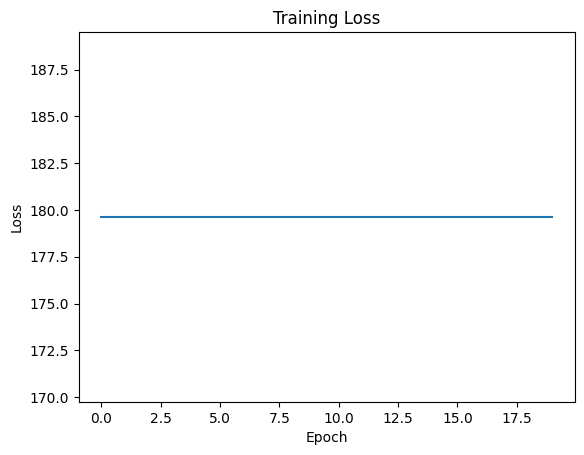

Saved PyTorch Model State to pretrained_models\GoreTex_StrainEnergyCANN_Ani\20240622_2324_0.pth
tensor([[0.5030, 0.7814, 0.7844, 0.1926, 0.0666, 0.1574, 0.3884, 0.6124, 0.0640,
         0.4922, 0.4166, 0.9438, 0.1140, 0.0773, 0.7914, 0.3989],
        [0.8170, 0.8779, 0.4958, 0.1065, 0.9729, 0.6549, 0.5920, 0.8493, 0.6936,
         0.9440, 0.7153, 0.1803, 0.8053, 0.3503, 0.5490, 0.6934]])
[ 6.0339327  6.770312   7.8920565  9.219498  10.814523  12.758333
 15.161748  18.181068  22.043524  27.08929   33.84414   30.209959
 24.391136  19.98895   16.582268  14.510231  12.234251  10.386649
  8.865236   7.5944386  6.516023   5.5828886  4.75475    3.9949455
  4.5848265  5.2052813  5.872818   6.6044903  7.418611   8.095467
  9.104764  10.260857  11.5961485 13.150956  14.9765625 17.139452
 18.373749  16.01095   14.026171  12.343206  10.903801   9.662591
  8.583546   7.862851   7.0000286  6.229531   5.5321207  4.8902054
  4.2870917  4.2065754  6.0339327  6.770312   7.8920565  9.219498
 10.814523  1

ValueError: Length mismatch: Expected axis has 12 elements, new values have 13 elements

In [14]:
# experiments=[["Tensile", "Comression"], ["Tensile", "Shear"], ["Shear", "Comression"], "Shear", "Tensile", "Compression"]
# experiments = ["Tensile", "Comression", "Shear"]
# models = [StrainEnergyCANN_C, StrainEnergyCANN_polinomial3]
models = [StrainEnergyCANN_Ani]
path = r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models"
for model in models:


    # for idx, experiment in enumerate(experiments):
        train_data_loader, test_data_loader = init_loaders(None)
        name = "GoreTex_" + str(model.__name__)
        print("----------------------------------------------------------------------")
        # print(experiment)
        test_train = Trainer(
            plot_valid=False,
            epochs=20,
            experiment_name=name,
            l2_reg_coeff=None,
            l1_reg_coeff=None,
            learning_rate=0.0001,
            checkpoint=None,
            model=model,
            
            # dtype = torch.float64
        )
        
        trained_model = test_train.train(train_data_loader, None, weighting_data=False)
    
        trained_model.eval()
        vpredictions = []
        vtargets = []
        for data in test_data_loader:
            features, target = data
            # vpredictions.append(zip(trained_model(features).detach().numpy()))
            vpredictions.append(trained_model(features).detach().numpy())
        # print(trained_model.get_potential())
        print(trained_model.potential_constants)
        vpredictions = np.array(vpredictions)
        print(vpredictions.transpose()[0])
        combined_data["P11_model_" + name] = vpredictions.transpose()[0]
        combined_data["P22_model_" + name] = vpredictions.transpose()[1]
        combined_data.to_csv(os.path.join(os.path.join(path, str(name)), "data.csv"))
        plot_results_by_experiment_type(combined_data)
        combined_data.pop("P11_model_" + name)
        combined_data.pop("P22_model_" + name)
# trained_model = StrainEnergyCANN_C()

# print("R2:", r2_score_own(vtargets, vpredictions))
# plt.figure(figsize=(10, 5))
# plt.plot(vpredictions, label='P_pred', color='red')
# plt.plot(vtargets, label='P_true', color='black')
# plt.xlabel('lambda/gamma')
# plt.ylabel('P')
# plt.title('Predictions vs. Targets')
# plt.legend()

plt.show()

In [ ]:
combined_data

In [ ]:
from collections import OrderedDict
import torch

# Provided weights
weights = [[-0.00000000e+00, -0.00000000e+00],
 [ 8.06281149e-01,  1.40696345e-03],
 [-0.00000000e+00, -0.00000000e+00],
 [ 6.46267161e-02,  2.84846843e-04],
 [-0.00000000e+00, -0.00000000e+00],
 [ 4.88660574e-01,  1.02614926e-03],
 [-0.00000000e+00, -0.00000000e+00],
 [ 1.09509790e+00,  1.44241273e-03],
 [ 1.32167622e-01,  2.50902846e-02],
 [ 6.15145266e-01,  1.99771114e-03],
 [ 1.48086607e+00,  8.69683549e-02],
 [ 4.96627361e-01,  1.48953160e-03],
 [ 1.23559475e+00,  9.31678526e-03],
 [ 9.03831899e-01,  1.09326339e-03],
 [-0.00000000e+00, -0.00000000e+00],
 [ 1.22360349e+00,  6.04832545e-04]]

weights = np.array(weights).transpose().reshape(32)
# Convert weights to tensors
weight_tensors = [torch.tensor([[w]]) for w in weights]

# Create OrderedDict
model_weights = OrderedDict([
    ('single_inv_net1.w11.weight', weight_tensors[0]),
    ('single_inv_net1.w21.weight', weight_tensors[1]),
    ('single_inv_net1.w31.weight', weight_tensors[2]),
    ('single_inv_net1.w41.weight', weight_tensors[3]),
    ('single_inv_net2.w11.weight', weight_tensors[4]),
    ('single_inv_net2.w21.weight', weight_tensors[5]),
    ('single_inv_net2.w31.weight', weight_tensors[6]),
    ('single_inv_net2.w41.weight', weight_tensors[7]),
    ('single_inv_net4.w11.weight', weight_tensors[8]),
    ('single_inv_net4.w21.weight', weight_tensors[9]),
    ('single_inv_net4.w31.weight', weight_tensors[10]),
    ('single_inv_net4.w41.weight', weight_tensors[11]),
    ('single_inv_net5.w11.weight', weight_tensors[12]),
    ('single_inv_net5.w21.weight', weight_tensors[13]),
    ('single_inv_net5.w31.weight', weight_tensors[14]),
    ('single_inv_net5.w41.weight', weight_tensors[15]),
    ('wx2.weight', torch.tensor([weight_tensors[16:]]))
])

# Display the model weights
for key, value in model_weights.items():
    print(f"{key}: {value}")


In [ ]:
trained_model =StrainEnergyCANN_Ani()
# trained_model.load_state_dict(torch.load(r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models\GoreTex_StrainEnergyCANN_Ani\20240530_0108_206.pth"))
trained_model.load_state_dict(model_weights)
trained_model.state_dict()
trained_model.get_potential()

$ 0.001407 * (e^{  0.806281 * (I1 - 3)} - 1)\\\\ + 0.000285 * (e^{  0.064627 * (I1 - 3) ^ 2} - 1)\\\\ + 0.001026 * (e^{  0.488661 * (I2 - 3))} - 1)\\\\ + 0.001442 * (e^{  1.095098 * (I2 - 3) ^ 2)} - 1) \\\\                               + 0.003316 * (I4 - 3) \\\\                + 0.001998 * (e^{  0.615145 * (I4 - 3)} - 1)\\\\                + 0.128788 * (I4 - 3) ^ 2 \\\\                + 0.001490 * (e^{  0.496627 * (I4 - 3) ^ 2} - 1)\\\\                                + 0.011512 * (I5 - 3) \\\\                + 0.001093 * (e^{  0.903832 * (I5 - 3))} - 1)\\\\ + 0.000605 * (e^{  1.223603 * (I5 - 3) ^ 2)} - 1)\\\\$

In [15]:
# trained_model.load_state_dict(torch.load(r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models\GoreTex_StrainEnergyCANN_Ani\20240530_0108_206.pth"))
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    # vpredictions.append(zip(trained_model(features).detach().numpy()))
    # print(trained_model(features))
    vpredictions.append(trained_model(features).detach().numpy())
# print(trained_model.get_potential())
print(trained_model.potential_constants)
vpredictions = np.array(vpredictions)
print(vpredictions.transpose()[0] - vpredictions.transpose()[1])
combined_data["P11_model_" + name] = vpredictions.transpose()[0]
combined_data["P22_model_" + name] = vpredictions.transpose()[1]
# combined_data.to_csv(os.path.join(os.path.join(path, str(name)), "data.csv"))
# plot_results_by_experiment_type("data.csv")
combined_data.pop("P11_model_" + name)
combined_data.pop("P22_model_" + name)

tensor([[0.5030, 0.7814, 0.7844, 0.1926, 0.0666, 0.1574, 0.3884, 0.6124, 0.0640,
         0.4922, 0.4166, 0.9438, 0.1140, 0.0773, 0.7914, 0.3989],
        [0.8170, 0.8779, 0.4958, 0.1065, 0.9729, 0.6549, 0.5920, 0.8493, 0.6936,
         0.9440, 0.7153, 0.1803, 0.8053, 0.3503, 0.5490, 0.6934]])
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.0144186  -0.02918243 -0.0448246  -0.06177902 -0.08041048 -0.09567547
 -0.11798191 -0.1427784  -0.17035294 -0.20102024 -0.23515129 -0.27319145
 -0.29384995 -0.25364876 -0.21762657 -0.18527699 -0.15619946 -0.13005161
 -0.10653496 -0.09045506 -0.07086468 -0.05311346 -0.03686428 -0.02172136
 -0.00720453 -0.01440382  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.       

0      6.033933
1      6.770312
2      7.892056
3      9.219498
4     10.814523
        ...    
95     6.282644
96     5.568985
97     4.911927
98     4.294296
99     4.220979
Name: P22_model_GoreTex_StrainEnergyCANN_Ani, Length: 100, dtype: float32

In [ ]:
data = pd.read_csv(r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\src\CANN_torch\uniaxial.csv")
plot_results_by_experiment_type(data)

In [ ]:
StrainEnergyCANN_Ani.__name__ = "test"
StrainEnergyCANN_Ani.__name__

$psi =   0.000000 * (I1 - 3) \\               + 0.026245 * (e^{  0.000000 * (I1 - 3)} - 1)\\               - 0.025429 * ln(1 - 0.052720 * (I1 - 3)) \\               + 0.000000 * (I1 - 3) ^ 2 \\               + 0.085033 * (e^{  0.000000 * (I1 - 3) ^ 2} - 1)\\               - 0.077004 * ln(1 - 0.046803 * (I1 - 3) ^ 2) \\                               + 0.006244 * (I2 - 3) \\               + 0.046553 * (e^{  0.060594 * (I2 - 3))} - 1)\\               - 0.123550* ln(1 - 0.126146 *  (I2 - 3)) \\               + 0.000000 * (I2 - 3) ^ 2 \\               + 0.132380 * (e^{  0.051048 *(I2 - 3) ^ 2)} - 1)\\               - 0.018332* ln(1 - 0.074555 * (I2 - 3) ^ 2)\\$